In [27]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.2-BETA7 (19/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.6 (20/Jan/2023)


# Trading with Carbon Order UI extensions (NBTest 51)

NBTEST: NOTEST_DEFAULT = TEST

In [28]:
PATH = np.array([1500.        , 1491.99074643, 1485.65718599, 1479.79158552,
       1466.58650982, 1433.05507163, 1569.49636858, 1539.19489793,
       1498.15218548, 1442.6821791 , 1363.45028675, 1328.43629812,
       1294.07754362, 1318.91694769, 1264.89691091, 1249.60958469,
       1277.91142551, 1353.60398307, 1492.94060514, 1529.89987743,
       1548.0584188 , 1516.09192102, 1542.73861583, 1608.14022479,
       1522.88237851, 1443.86148065, 1507.22226307, 1381.74206561,
       1302.01268179, 1172.96837719, 1357.84363975, 1367.73136865,
       1419.54264794, 1408.69980729, 1511.01996309, 1495.00267224,
       1638.28920143, 1616.58301765, 1620.92074371, 1620.53530268,
       1571.84813276, 1509.53587407, 1380.33068895, 1294.75314398,
       1310.05268545, 1371.99177615, 1320.69828255, 1420.48399288,
       1356.71295438, 1353.51188774, 1424.22279717, 1476.14612579,
       1624.24552552, 1513.55598664, 1519.64919189, 1614.3341273 ,
       1412.7521227 , 1406.23336746, 1362.07578138, 1217.71952751,
       1236.84447637, 1254.13928287, 1271.25628679, 1363.41265863,
       1385.43744959, 1326.59010815, 1339.03782276, 1324.07762939,
       1299.50430743, 1304.43938692, 1286.071414  , 1428.25422314,
       1439.68537894, 1513.9136792 , 1603.29667897, 1576.16427903,
       1706.00889461, 1769.02376434, 1771.05707198, 1679.96135525,
       1671.89677916, 1482.57194787, 1462.23509373, 1385.40848718,
       1440.82389235, 1481.69759044, 1510.3400991 , 1585.61358711,
       1471.61710324, 1402.54813158, 1472.79445902, 1575.39249821,
       1556.51476627, 1544.3787445 , 1530.82965887, 1619.77018789,
       1638.30058665, 1670.33267938, 1609.79564666, 1528.40194762,
       1560.98331845])
TIME = np.linspace(0,1,len(PATH))

In [29]:
amt_usdc    = 1000
amt_eth     = 1
spot0 = 1500
w0 = 0.05
w1 = 2*w0

p_buy_a = spot0*(1-w0)
p_buy_b = spot0*(1-w0)*(1-w1)
p_sell_a = spot0*(1+w0)
p_sell_b = spot0*(1+w0)*(1+w1)

In [30]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
Sim.state()["orders"]

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,1.0,1.0,ETH,False,1575.0,1732.5,1575.0,USDC per ETH,1
1,1,ETHUSDC,USDC,1000.0,1000.0,USDC,False,1425.0,1282.5,1425.0,USDC per ETH,0


bid 1282.5-1425.0, spot 1500, ask 1575.0-1732.5


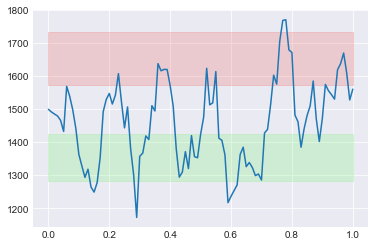

In [31]:
plt.plot(TIME, PATH)
plt.fill_between(TIME, p_buy_a, p_buy_b, color="lightgreen", alpha=0.3)
plt.fill_between(TIME, p_sell_a, p_sell_b, color="lightcoral", alpha=0.3)
plt.grid(visible=True)
print(f"bid {p_buy_b:.1f}-{p_buy_a:.1f}, spot {spot0}, ask {p_sell_a:.1f}-{p_sell_b:.1f}")

## without using tradeto [NOTEST]

In [32]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
print()
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")
print("-"*20)
printdots = True
#Sim.state()["orders"]

for t, spot, ix in zip(TIME, PATH, range(len(PATH))):
    orderuis = Sim.state()["orderuis"]
    orders_sell_eth = {k:v for k,v in orderuis.items() if v.tkn=="ETH"}
    dy_f_sell_eth = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_eth.values())
    sell_eth  = dy_f_sell_eth(spot)
    orders_sell_usdc = {k:v for k,v in orderuis.items() if v.tkn=="USDC"}
    dy_f_sell_usdc = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_usdc.values())
    sell_usdc = dy_f_sell_usdc(spot)
    
    if sell_eth > 0.0001:
        r = Sim.amm_sells("ETH", sell_eth, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_eth:10.2f} ETH {failed}")
        printdots = True
    
    elif sell_usdc > 0.001:
        r = Sim.amm_sells("USDC", sell_usdc, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_usdc:10.2f} USDC {failed}")
        printdots = True
    
    else:
        if printdots:
            print("...")
        printdots = False
        #print(f"ix={ix:4.0f}, spot={spot:0.1f}: ---")

o = Sim.state()["orders"]
#print(f"ix={ix:4.0f}, spot={spot:0.1f}: -- sim  finished --")
amt_eth_final = abs(float(o.query("tkn=='ETH'")["y"]))
amt_usdc_final = abs(float(o.query("tkn=='USDC'")["y"]))
print("-"*20)
print(f"ix={0:4.0f},  spot={PATH[0]:0.1f}: {amt_eth:.1f} ETH {amt_usdc:.1f} USDC (={amt_eth*PATH[0]+amt_usdc:.1f} USDC)")
print(f"ix={ix:4.0f},  spot={spot:0.1f}: {amt_eth_final:.1f} ETH {amt_usdc_final:.1f} USDC (={amt_eth_final*spot+amt_usdc_final:.1f} USDC)")
print()
o


buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5
--------------------
...
ix=  10, spot=1363.5: sell     425.49 USDC 
ix=  11, spot=1328.4: sell     246.34 USDC 
ix=  12, spot=1294.1: sell     244.91 USDC 
...
ix=  14, spot=1264.9: sell      83.26 USDC 
...
ix=  23, spot=1608.1: sell       0.39 ETH 
...
ix=  28, spot=1302.0: sell     476.11 USDC 
ix=  29, spot=1173.0: sell     140.10 USDC 
...
ix=  36, spot=1638.3: sell       0.76 ETH 
...
ix=  42, spot=1380.3: sell     376.72 USDC 
ix=  43, spot=1294.8: sell     739.16 USDC 
...
ix=  52, spot=1624.2: sell       0.62 ETH 
...
ix=  57, spot=1406.2: sell      27.24 USDC 
ix=  58, spot=1362.1: sell     374.89 USDC 
ix=  59, spot=1217.7: sell     691.26 USDC 
...
ix=  74, spot=1603.3: sell       0.40 ETH 
...
ix=  76, spot=1706.0: sell       1.35 ETH 
ix=  77, spot=1769.0: sell       0.33 ETH 
...
ix=  83, spot=1385.4: sell     934.09 USDC 
...
--------------------
ix=   0,  spot=1500.0: 1.0 ETH 1000.0 USDC (=2500.0 USDC)
ix= 100,  spot=1561

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,2.074261,0.664800,ETH,False,1575.0,1732.5,1679.542113,USDC per ETH,1
1,1,ETHUSDC,USDC,3426.417620,2492.330734,USDC,False,1425.0,1282.5,1385.408487,USDC per ETH,0


In [33]:
global AMOUNTS

AMOUNTS = {
    "usdc": amt_usdc_final,
    "eth":  amt_eth_final,
    "val": amt_eth_final*spot+amt_usdc_final,
}

## with using tradeto

In [34]:
Sim = CarbonSimulatorUI(pair="ETH/USDC")
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
ouis = Sim.state()["orderuis"]
ouis

{0: CarbonOrderUI(pair=ETH/USDC, tkn=ETH, B=0.024024999005214903, S=0.0011726325287335776, yint=1.0, y=1.0, id=0, linked=<1>),
 1: CarbonOrderUI(pair=ETH/USDC, tkn=USDC, B=35.812009158939965, S=1.9371630174137806, yint=1000.0, y=1000.0, id=1, linked=<0>)}

In [35]:
ethamt_r  = [ouis[0].y]
usdcamt_r = [ouis[1].y]
for spot in PATH[1:]:
    r0 = ouis[0].tradeto(spot)
    r1 = ouis[1].tradeto(spot)
    ethamt_r  += [ouis[0].y]
    usdcamt_r += [ouis[1].y]
ethamt_r  = np.array(ethamt_r)
usdcamt_r = np.array(usdcamt_r)

t=0.0:  1.0 ETH   1000 USDC (value 2500.0 USDC)
t=1.0:  0.7 ETH   2492 USDC (value 3530.1 USDC)


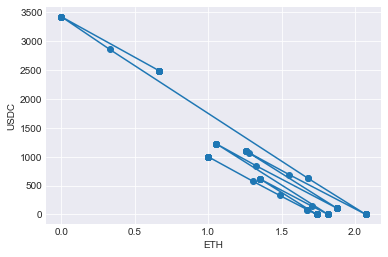

In [36]:
#plt.scatter(x=ethamt_r, y=usdcamt_r)
print(f"t={0:3.1f}: {ethamt_r[0]:4.1f} ETH {usdcamt_r[0]:6.0f} USDC (value {ethamt_r[0]*PATH[0]+usdcamt_r[0]:6.1f} USDC)")
print(f"t={1:3.1f}: {ethamt_r[-1]:4.1f} ETH {usdcamt_r[-1]:6.0f} USDC (value {ethamt_r[-1]*PATH[-1]+usdcamt_r[-1]:6.1f} USDC)")
plt.plot(ethamt_r, usdcamt_r, "-o")
plt.xlabel("ETH")
plt.ylabel("USDC")
plt.grid()

t=1.0:  0.7 ETH   2492 USDC (value 3530.1 USDC)


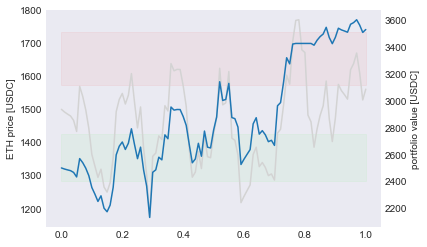

In [37]:
value_r = ethamt_r * PATH + usdcamt_r
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(TIME, PATH, color="lightgrey")
ax1.fill_between(TIME, p_buy_a, p_buy_b, color="lightgreen", alpha=0.1)
ax1.fill_between(TIME, p_sell_a, p_sell_b, color="lightcoral", alpha=0.1)
ax2.plot(TIME, value_r)
plt.xlabel("time")
ax2.set_ylabel("portfolio value [USDC]")
ax1.set_ylabel("ETH price [USDC]")
print(f"t={1:3.1f}: {ethamt_r[-1]:4.1f} ETH {usdcamt_r[-1]:6.0f} USDC (value {ethamt_r[-1]*PATH[-1]+usdcamt_r[-1]:6.1f} USDC)")

In [38]:
if 'AMOUNTS' in globals():
    print(f"with tradeto: {AMOUNTS['eth']:6.4f} ETH {AMOUNTS['usdc']:6.2f} USDC (value {AMOUNTS['val']:6.2f} USDC)")
    print(f"without:      {ethamt_r[-1]:6.4f} ETH {usdcamt_r[-1]:6.2f} USDC (value {ethamt_r[-1]*PATH[-1]+usdcamt_r[-1]:6.2f} USDC)")
    assert round(AMOUNTS['eth'],8) == round(ethamt_r[-1],8)
    assert round(AMOUNTS['usdc'],8) == round(usdcamt_r[-1],8)
    assert round(AMOUNTS['val'],8) == round(ethamt_r[-1]*PATH[-1]+usdcamt_r[-1],8)
pass

with tradeto: 0.6648 ETH 2492.33 USDC (value 3530.07 USDC)
without:      0.6648 ETH 2492.33 USDC (value 3530.07 USDC)


In [39]:
assert ",".join([f"{int(x)}" for x in value_r]) == """
2500,2491,2485,2479,2466,2433,2569,2539,2498,2442,2354,2305,2250,
2292,2200,2173,2223,2354,2597,2661,2693,2637,2683,2791,2675,2569,
2654,2485,2365,2131,2467,2485,2580,2560,2746,2717,2953,2930,2934,
2934,2883,2817,2674,2538,2567,2683,2587,2774,2654,2648,2781,2878,
3141,3002,3009,3129,2874,2866,2804,2525,2565,2601,2636,2828,2873,
2751,2777,2746,2695,2705,2667,2962,2986,3140,3320,3274,3422,3426,
3426,3426,3426,3426,3426,3413,3450,3477,3496,3546,3470,3424,3471,
3539,3527,3519,3510,3569,3581,3602,3562,3508,3530
""".replace("\n", "").replace(" ", "")